In [ ]:
import os
import pandas as pd

def concat_csv_files(directory):
    # List to store individual DataFrames
    all_dataframes = []
    
    # Iterate through all files in the directory
    for filename in os.listdir(directory):
        if filename.endswith(".csv"):
            file_path = os.path.join(directory, filename)
            # Read the CSV file and append to the list
            df = pd.read_csv(file_path)
            all_dataframes.append(df)
    
    # Concatenate all DataFrames in the list
    if all_dataframes:
        combined_df = pd.concat(all_dataframes, ignore_index=True)
        
        # Write the combined DataFrame to a new CSV file
        output_path = os.path.join(directory, "combined_output.csv")
        combined_df.to_csv(output_path, index=False)
        print(f"Combined CSV saved to: {output_path}")
    else:
        print("No CSV files found in the directory.")

# Example usage
directory_path = "/projects/genomic-ml/da2343/ml_project_2/unsupervised/kmeans/strategy_figures"
concat_csv_files(directory_path)

Inverted strategies: ['EUR_USD_M15', 'GBP_CHF_M15', 'GBP_JPY_M15', 'USD_CAD_M15', 'USD_CHF_M15']


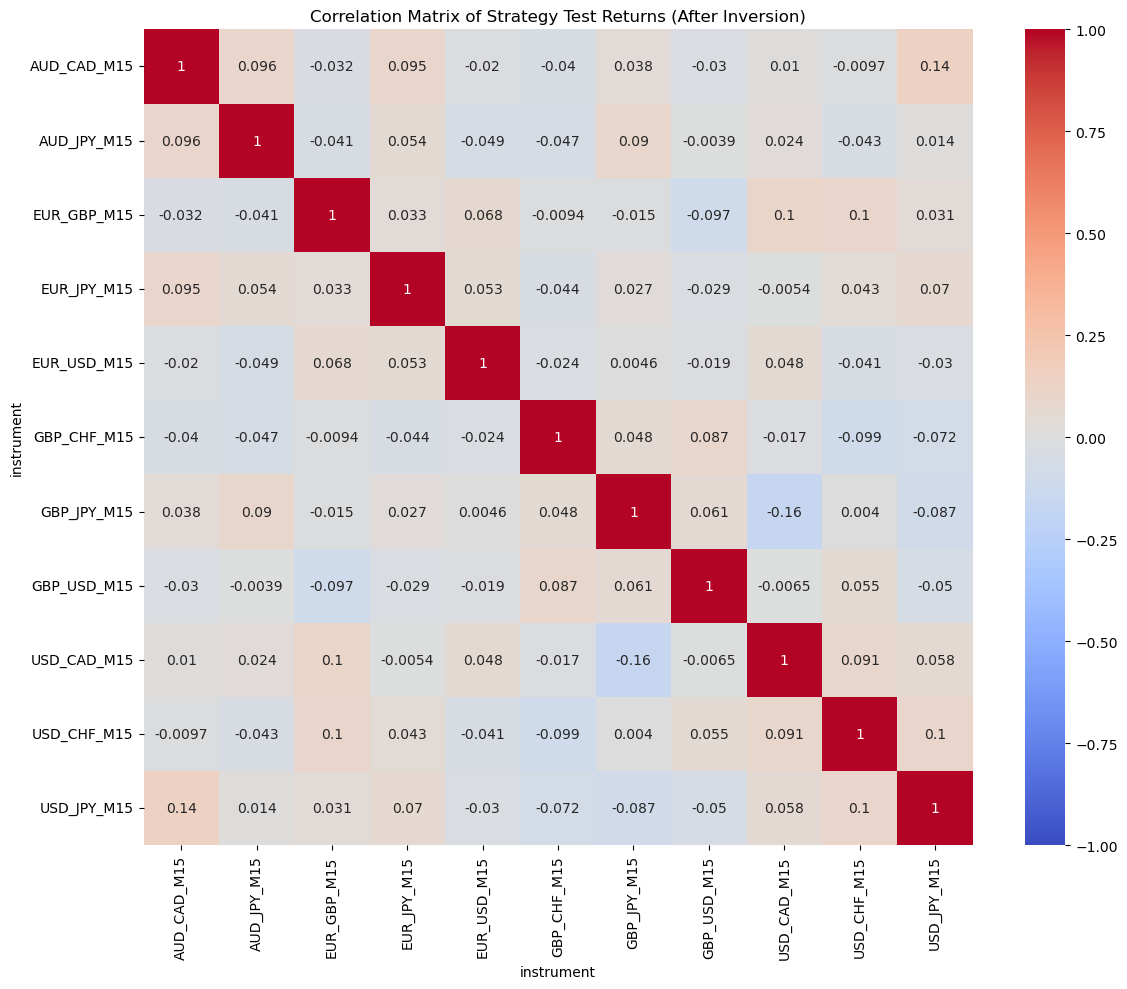

Uncorrelated Strategy Pairs:
AUD_CAD_M15 and AUD_JPY_M15
AUD_CAD_M15 and EUR_GBP_M15
AUD_CAD_M15 and EUR_JPY_M15
AUD_CAD_M15 and EUR_USD_M15
AUD_CAD_M15 and GBP_CHF_M15
AUD_CAD_M15 and GBP_JPY_M15
AUD_CAD_M15 and GBP_USD_M15
AUD_CAD_M15 and USD_CAD_M15
AUD_CAD_M15 and USD_CHF_M15
AUD_CAD_M15 and USD_JPY_M15


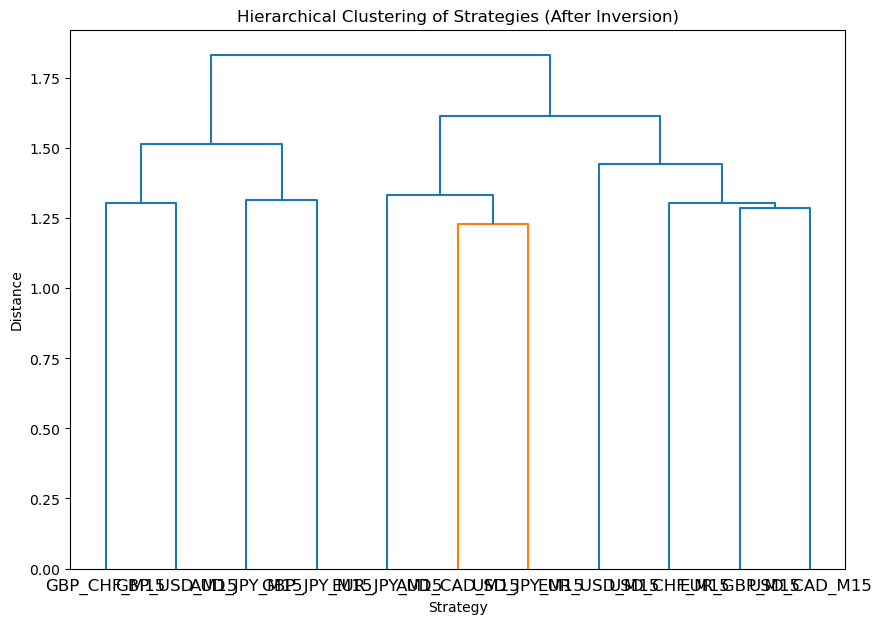


Performance Metrics (After Inversion):
             Total Return  Average Return  Standard Deviation  Sharpe Ratio
instrument                                                                 
GBP_USD_M15         920.0        1.854839            7.282683      0.254692
GBP_CHF_M15         936.0        1.733333            7.191729      0.241018
EUR_GBP_M15        1428.0        2.694340           11.451590      0.235281
EUR_USD_M15         858.0        1.606742            6.837077      0.235004
AUD_JPY_M15        1556.0        2.902985           12.491414      0.232398
USD_JPY_M15         771.0        2.909434           12.534169      0.232120
AUD_CAD_M15         712.0        2.646840           13.064628      0.202596
EUR_JPY_M15         445.0        1.654275            8.911431      0.185635
USD_CAD_M15        1204.0        2.263158           12.590550      0.179751
GBP_JPY_M15         858.0        1.571429            9.901692      0.158703
USD_CHF_M15         587.0        2.150183       

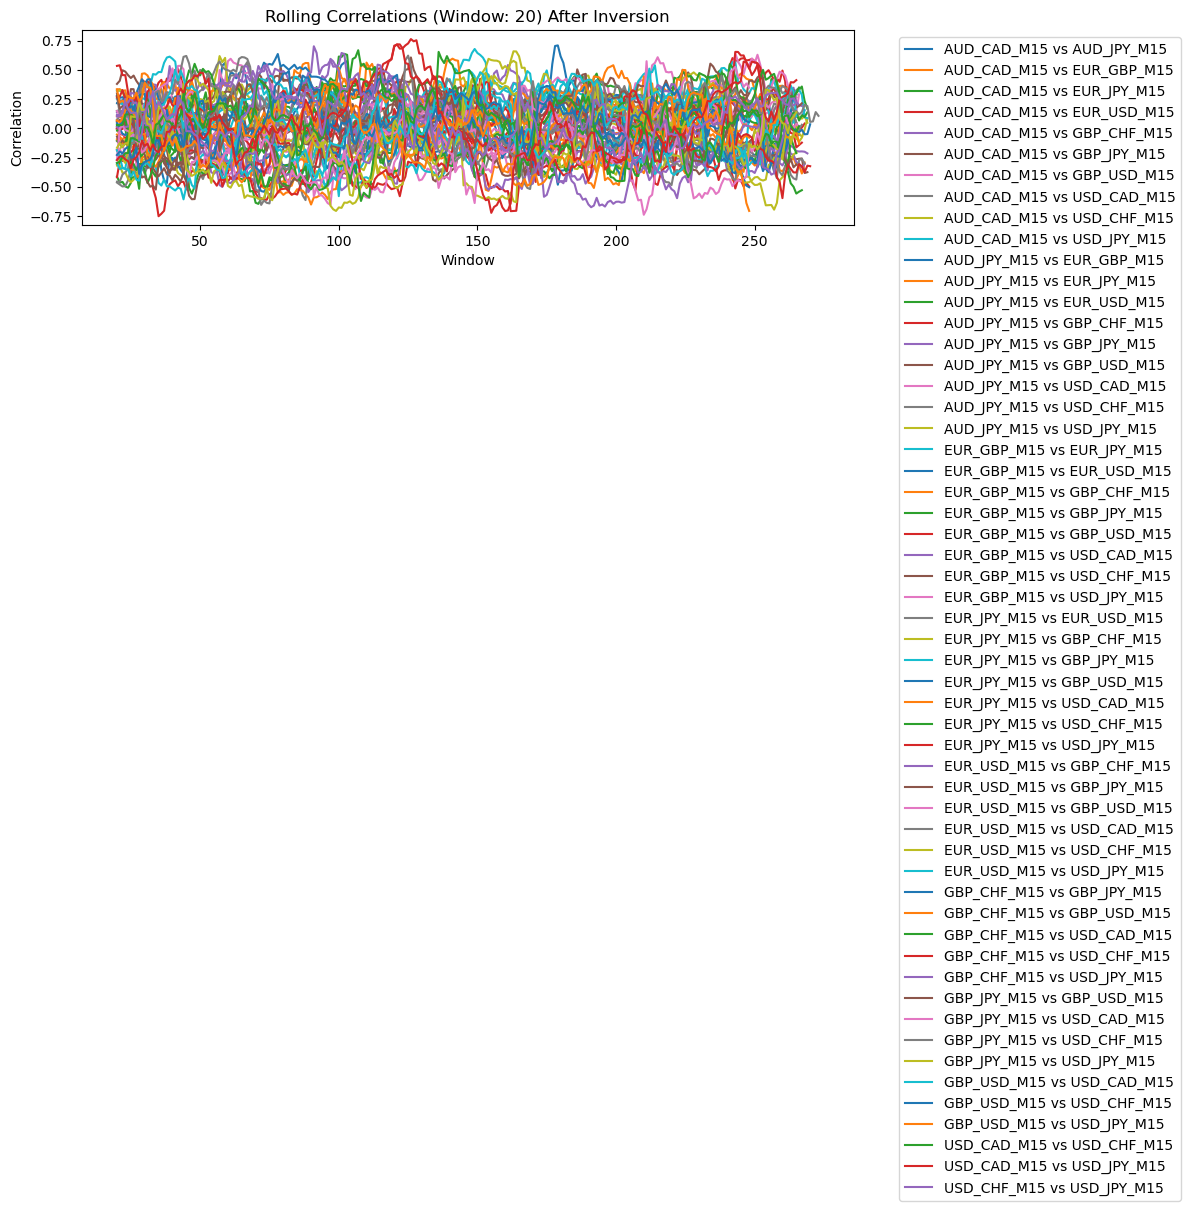

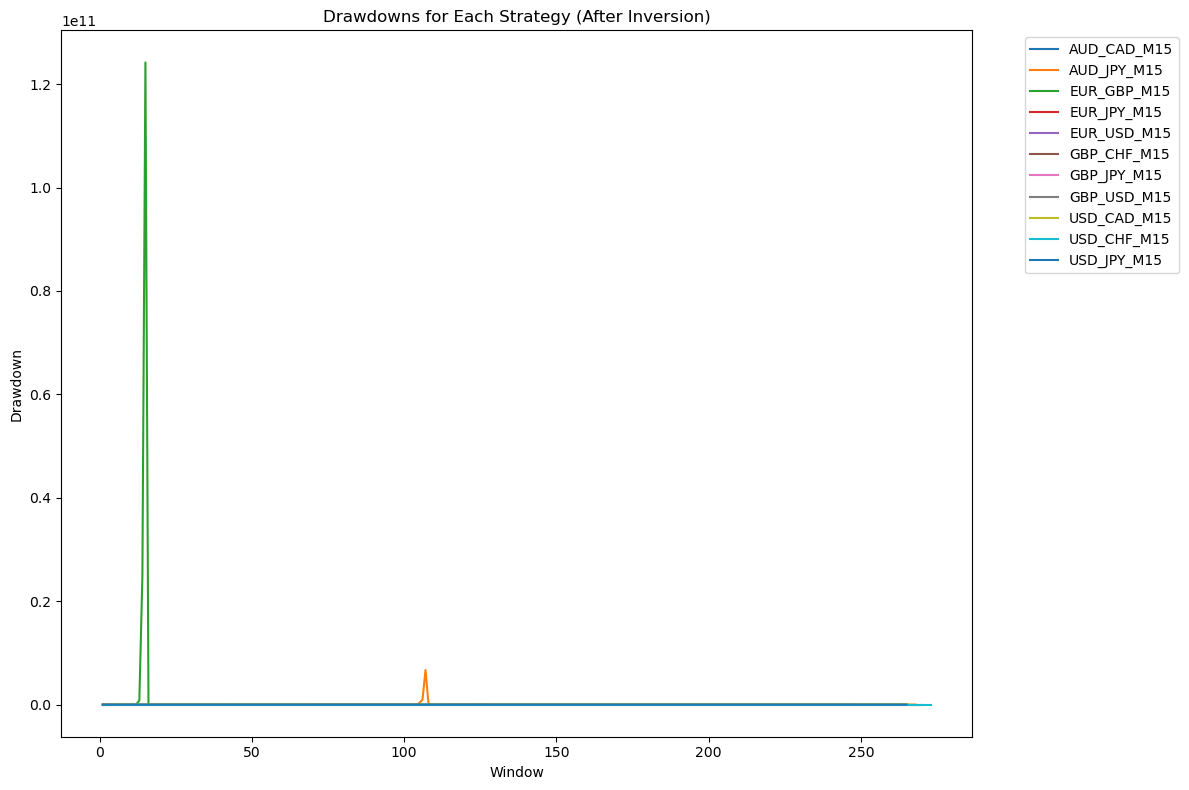


Top 10 Strategies with Lowest Maximum Drawdown:
instrument
EUR_USD_M15    -0.0
GBP_CHF_M15     1.0
USD_CHF_M15    11.0
dtype: float64


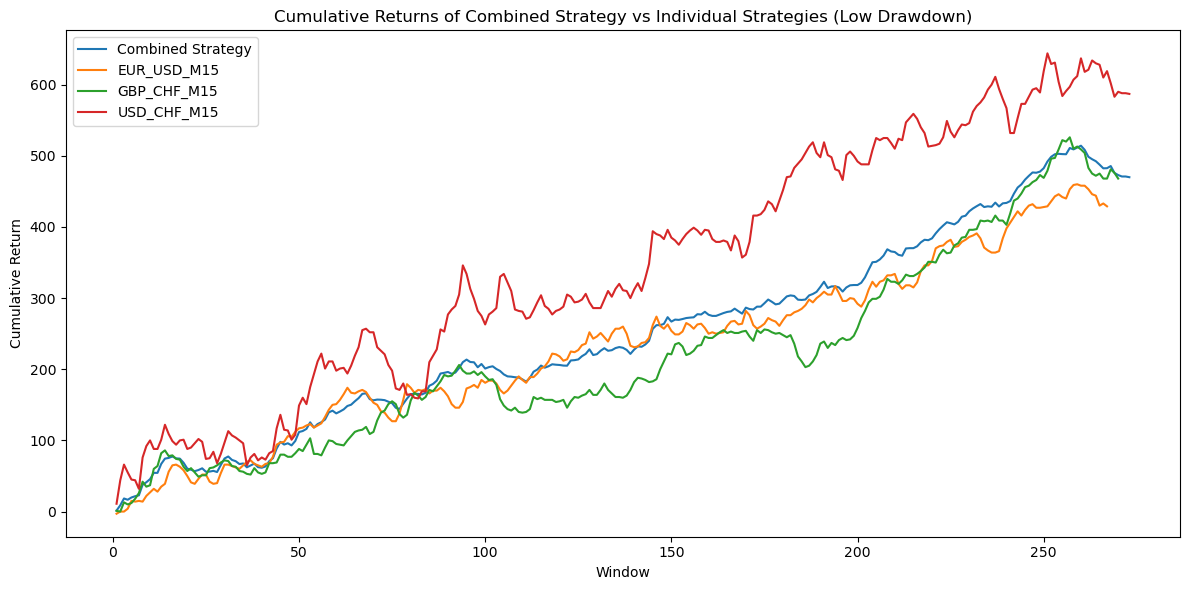


Analysis complete. Please check the generated plots for visual insights.


In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.spatial.distance import pdist, squareform
from sklearn.preprocessing import StandardScaler

# Load the data
df = pd.read_csv('combined_output.csv')

# Invert strategies with negative portfolios
def invert_negative_strategies(df):
    strategy_returns = df.groupby('instrument')['test_total_actual_return'].sum()
    negative_strategies = strategy_returns[strategy_returns < 0].index
    df.loc[df['instrument'].isin(negative_strategies), 'test_total_actual_return'] *= -1
    print("Inverted strategies:", list(negative_strategies))
    return df

# Apply the inversion
df = invert_negative_strategies(df)

# 1. Correlation Matrix and Heatmap
def plot_correlation_matrix(df):
    agg_df = df.groupby(['window', 'instrument'])['test_total_actual_return'].mean().reset_index()
    pivot_df = agg_df.pivot(index='window', columns='instrument', values='test_total_actual_return')
    corr_matrix = pivot_df.corr()
    
    plt.figure(figsize=(12, 10))
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1, center=0)
    plt.title('Correlation Matrix of Strategy Test Returns (After Inversion)')
    plt.tight_layout()
    plt.show()
    
    return corr_matrix

# 2. Uncorrelated Strategy Pairs
def find_uncorrelated_pairs(corr_matrix, threshold=0.2):
    uncorrelated_pairs = []
    for i in range(len(corr_matrix.columns)):
        for j in range(i+1, len(corr_matrix.columns)):
            if abs(corr_matrix.iloc[i, j]) < threshold:
                uncorrelated_pairs.append((corr_matrix.columns[i], corr_matrix.columns[j]))
    return uncorrelated_pairs

# 3. Hierarchical Clustering
def plot_dendrogram(corr_matrix):
    # Convert correlation matrix to distance matrix
    dist_matrix = 1 - corr_matrix
    condensed_dist = pdist(dist_matrix)
    linkage_matrix = linkage(condensed_dist, method='ward')
    
    plt.figure(figsize=(10, 7))
    dendrogram(linkage_matrix, labels=corr_matrix.columns)
    plt.title('Hierarchical Clustering of Strategies (After Inversion)')
    plt.xlabel('Strategy')
    plt.ylabel('Distance')
    plt.show()

# 4. Performance Metrics
def calculate_performance_metrics(df):
    grouped = df.groupby('instrument')
    total_returns = grouped['test_total_actual_return'].sum()
    avg_returns = grouped['test_total_actual_return'].mean()
    std_returns = grouped['test_total_actual_return'].std()
    sharpe_ratios = avg_returns / std_returns
    
    metrics = pd.DataFrame({
        'Total Return': total_returns,
        'Average Return': avg_returns,
        'Standard Deviation': std_returns,
        'Sharpe Ratio': sharpe_ratios
    })
    
    return metrics.sort_values('Sharpe Ratio', ascending=False)

# 5. Time-varying Correlations
def plot_rolling_correlations(df, window=20):
    agg_df = df.groupby(['window', 'instrument'])['test_total_actual_return'].mean().reset_index()
    pivot_df = agg_df.pivot(index='window', columns='instrument', values='test_total_actual_return')
    rolling_corr = pivot_df.rolling(window=window).corr()
    
    plt.figure(figsize=(12, 8))
    for i in range(len(pivot_df.columns)):
        for j in range(i+1, len(pivot_df.columns)):
            plt.plot(rolling_corr.index.levels[0], rolling_corr.loc[(slice(None), pivot_df.columns[i]), pivot_df.columns[j]], 
                     label=f'{pivot_df.columns[i]} vs {pivot_df.columns[j]}')
    
    plt.title(f'Rolling Correlations (Window: {window}) After Inversion')
    plt.xlabel('Window')
    plt.ylabel('Correlation')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

# 6. Drawdown Analysis
def calculate_drawdowns(df):
    agg_df = df.groupby(['window', 'instrument'])['test_total_actual_return'].mean().reset_index()
    pivot_df = agg_df.pivot(index='window', columns='instrument', values='test_total_actual_return')
    cumulative_returns = (1 + pivot_df).cumprod()
    drawdowns = (cumulative_returns.cummax() - cumulative_returns) / cumulative_returns.cummax()
    return drawdowns

def plot_drawdowns(drawdowns):
    plt.figure(figsize=(12, 8))
    for column in drawdowns.columns:
        plt.plot(drawdowns.index, drawdowns[column], label=column)
    plt.title('Drawdowns for Each Strategy (After Inversion)')
    plt.xlabel('Window')
    plt.ylabel('Drawdown')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

# 7. Strategy Combination
def combine_strategies(df, strategies):
    strategy_df = df[df['instrument'].isin(strategies)]
    combined_returns = strategy_df.groupby('window')['test_total_actual_return'].mean()
    return combined_returns

# Main execution
if __name__ == "__main__":
    # 1. Correlation Matrix and Heatmap
    corr_matrix = plot_correlation_matrix(df)
    
    # 2. Uncorrelated Strategy Pairs
    uncorrelated_pairs = find_uncorrelated_pairs(corr_matrix)
    print("Uncorrelated Strategy Pairs:")
    for pair in uncorrelated_pairs[:10]:  # Print first 10 pairs
        print(f"{pair[0]} and {pair[1]}")
    
    # 3. Hierarchical Clustering
    plot_dendrogram(corr_matrix)
    
    # 4. Performance Metrics
    performance_metrics = calculate_performance_metrics(df)
    print("\nPerformance Metrics (After Inversion):")
    print(performance_metrics)
    
    # 5. Time-varying Correlations
    plot_rolling_correlations(df)
    
    # 6. Drawdown Analysis
    drawdowns = calculate_drawdowns(df)
    plot_drawdowns(drawdowns)
    
    # Calculate maximum drawdown for each strategy
    max_drawdowns = drawdowns.max()
    top_10_low_drawdown = max_drawdowns.nsmallest(3)
    
    print("\nTop 10 Strategies with Lowest Maximum Drawdown:")
    print(top_10_low_drawdown)
    
    # 7. Strategy Combination
    low_drawdown_strategies = top_10_low_drawdown.index.tolist()
    combined_returns = combine_strategies(df, low_drawdown_strategies)
    
    plt.figure(figsize=(12, 6))
    plt.plot(combined_returns.index, combined_returns.cumsum(), label='Combined Strategy')
    for strategy in low_drawdown_strategies:
        strategy_returns = df[df['instrument'] == strategy].groupby('window')['test_total_actual_return'].mean()
        plt.plot(strategy_returns.index, strategy_returns.cumsum(), label=strategy)
    plt.title('Cumulative Returns of Combined Strategy vs Individual Strategies (Low Drawdown)')
    plt.xlabel('Window')
    plt.ylabel('Cumulative Return')
    plt.legend()
    plt.tight_layout()
    plt.show()

    print("\nAnalysis complete. Please check the generated plots for visual insights.")

Inverted strategies: ['EUR_USD_M15', 'GBP_CHF_M15', 'GBP_JPY_M15', 'USD_CAD_M15', 'USD_CHF_M15']


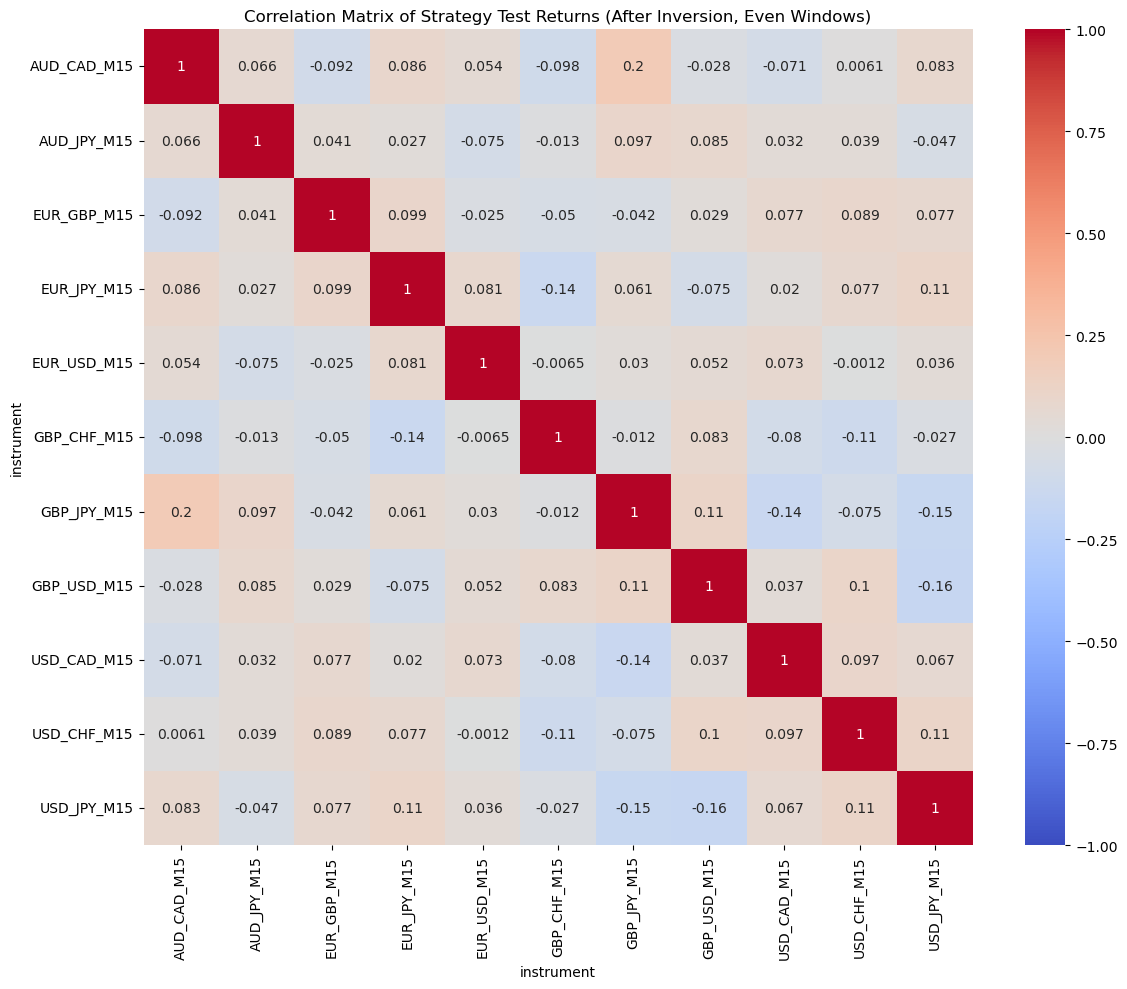

Uncorrelated Strategy Pairs:
AUD_CAD_M15 and AUD_JPY_M15
AUD_CAD_M15 and EUR_GBP_M15
AUD_CAD_M15 and EUR_JPY_M15
AUD_CAD_M15 and EUR_USD_M15
AUD_CAD_M15 and GBP_CHF_M15
AUD_CAD_M15 and GBP_JPY_M15
AUD_CAD_M15 and GBP_USD_M15
AUD_CAD_M15 and USD_CAD_M15
AUD_CAD_M15 and USD_CHF_M15
AUD_CAD_M15 and USD_JPY_M15


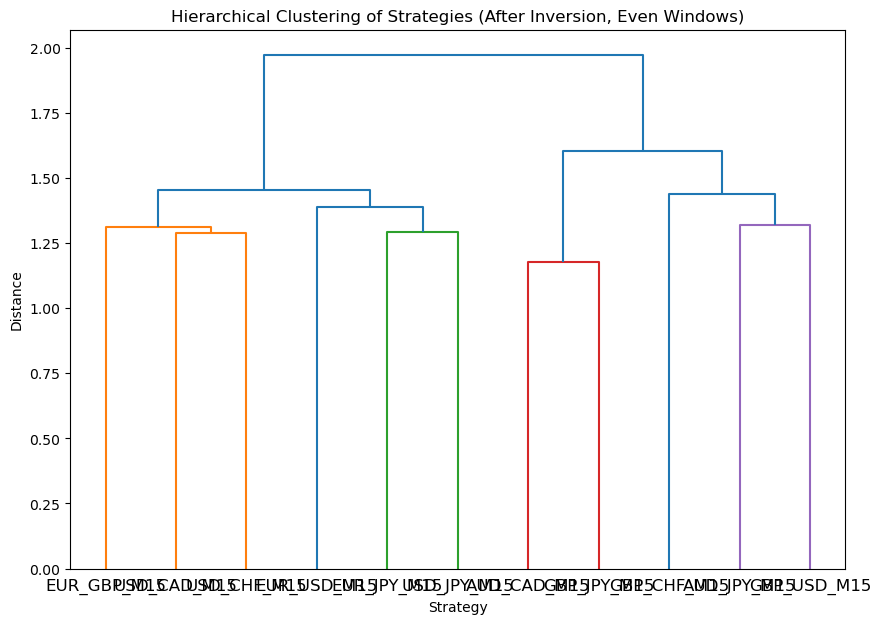


Performance Metrics (After Inversion, Even Windows):
             Total Return  Average Return  Standard Deviation  Sharpe Ratio
instrument                                                                 
AUD_JPY_M15         920.0        3.432836           11.890542      0.288703
USD_JPY_M15         451.0        3.416667           13.033745      0.262140
GBP_USD_M15         430.0        1.733871            6.915463      0.250724
AUD_CAD_M15         440.0        3.283582           13.581064      0.241777
EUR_USD_M15         372.0        1.398496            6.578341      0.212591
USD_CAD_M15         682.0        2.563910           13.435719      0.190828
EUR_GBP_M15         566.0        2.143939           11.238265      0.190771
EUR_JPY_M15         193.0        1.440299            8.886512      0.162077
GBP_JPY_M15         406.0        1.492647           10.118119      0.147522
GBP_CHF_M15         280.0        1.037037            7.431879      0.139539
USD_CHF_M15         225.0        1

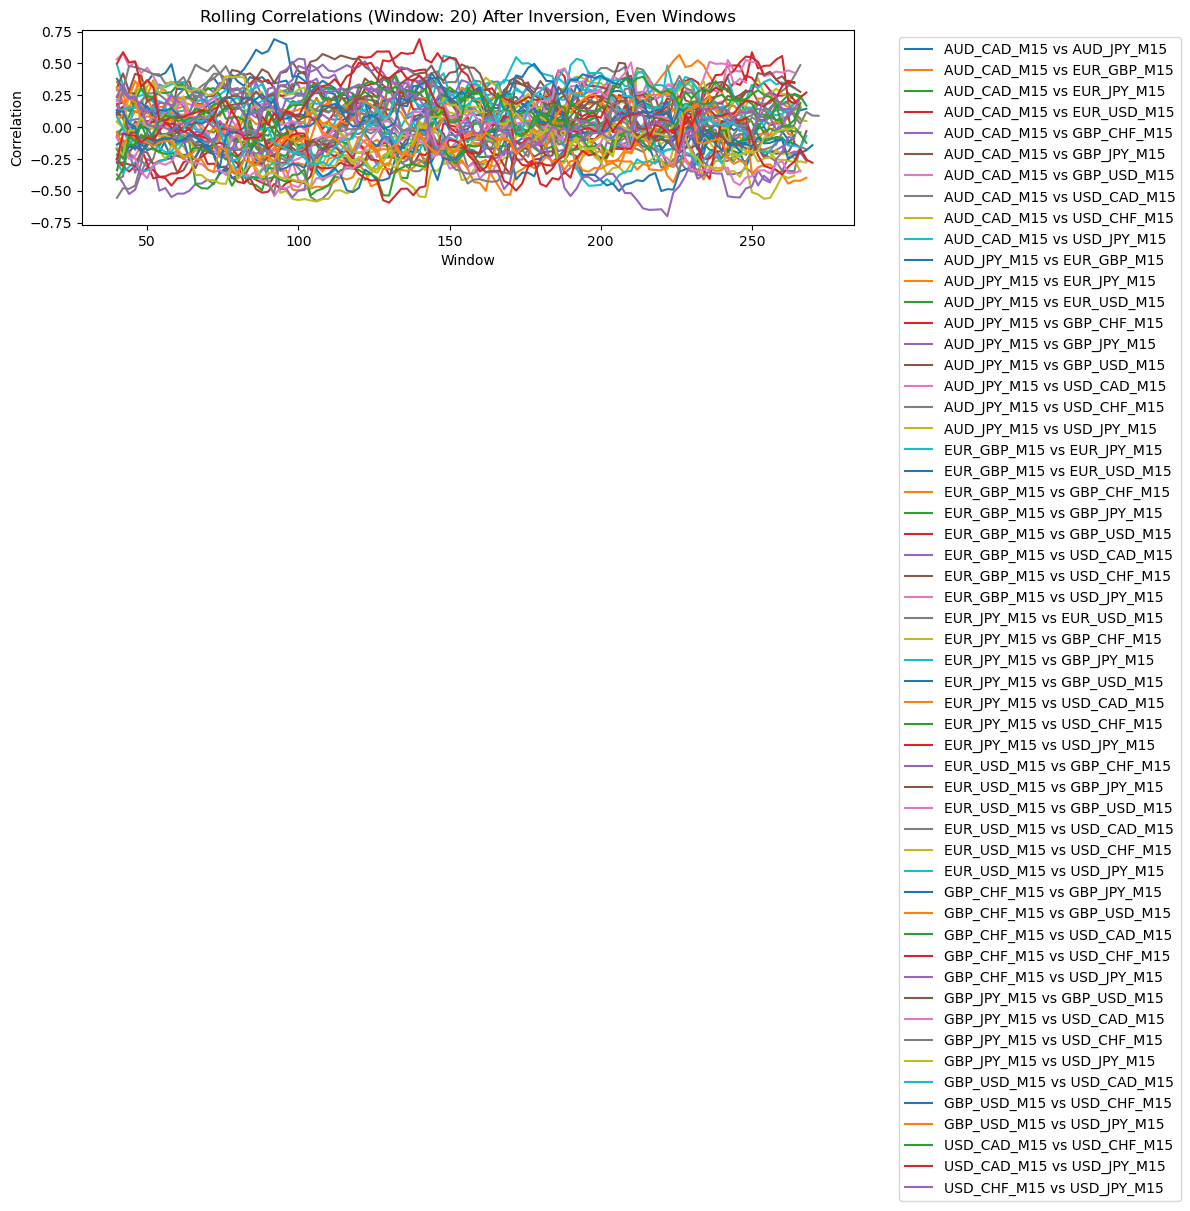

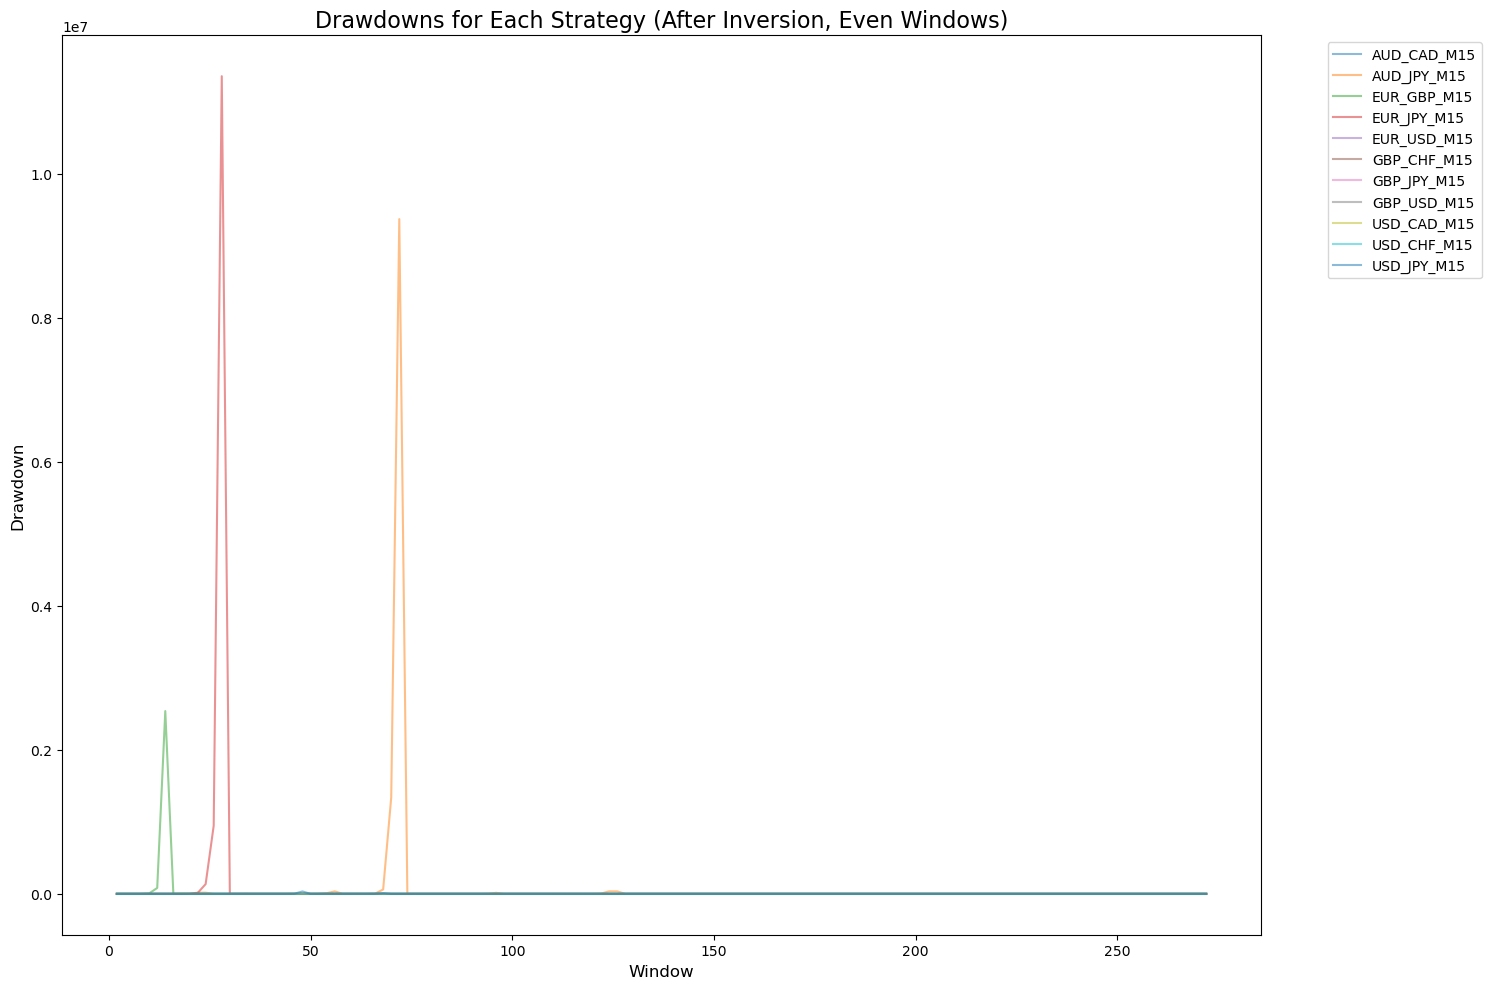


Top 10 Strategies with Lowest Maximum Drawdown:
instrument
GBP_CHF_M15          0.0
EUR_USD_M15          1.0
USD_CHF_M15         11.0
GBP_JPY_M15         43.0
AUD_CAD_M15        256.0
GBP_USD_M15       1729.0
USD_CAD_M15       6721.0
USD_JPY_M15      33661.0
EUR_GBP_M15    2538901.0
AUD_JPY_M15    9372133.0
dtype: float64

Win Rate of Combined Strategy: 69.85%


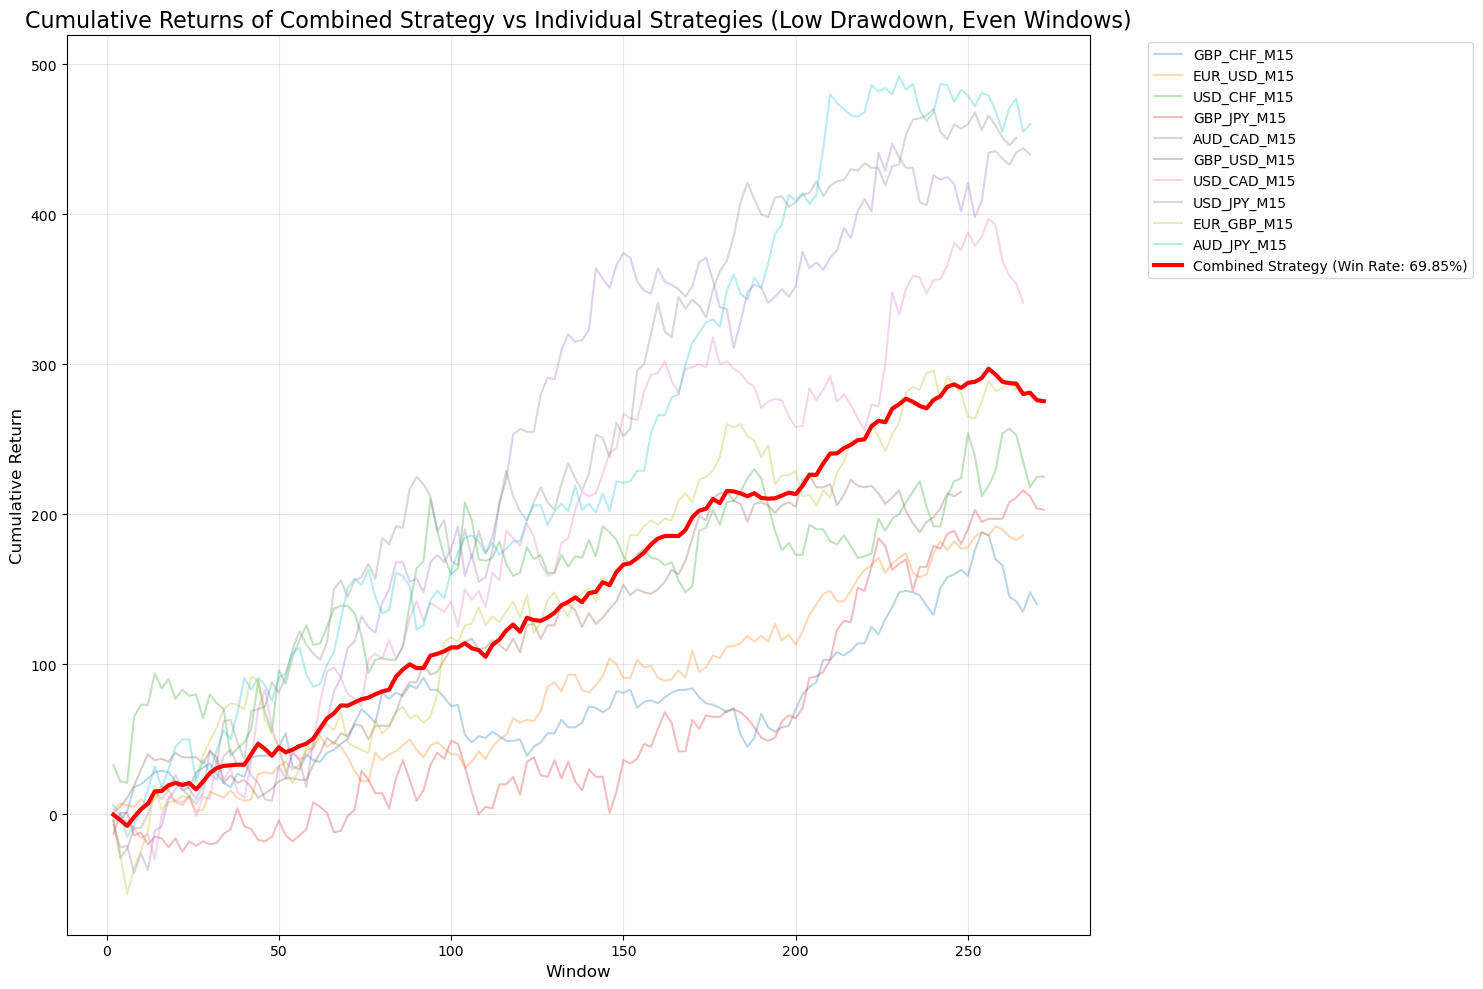


Win Rate Analysis:
Combined Strategy Win Rate: 69.85%
GBP_CHF_M15 Win Rate: 51.85%
EUR_USD_M15 Win Rate: 56.39%
USD_CHF_M15 Win Rate: 51.47%
GBP_JPY_M15 Win Rate: 50.00%
AUD_CAD_M15 Win Rate: 54.48%
GBP_USD_M15 Win Rate: 56.45%
USD_CAD_M15 Win Rate: 51.13%
USD_JPY_M15 Win Rate: 57.58%
EUR_GBP_M15 Win Rate: 57.58%
AUD_JPY_M15 Win Rate: 58.96%


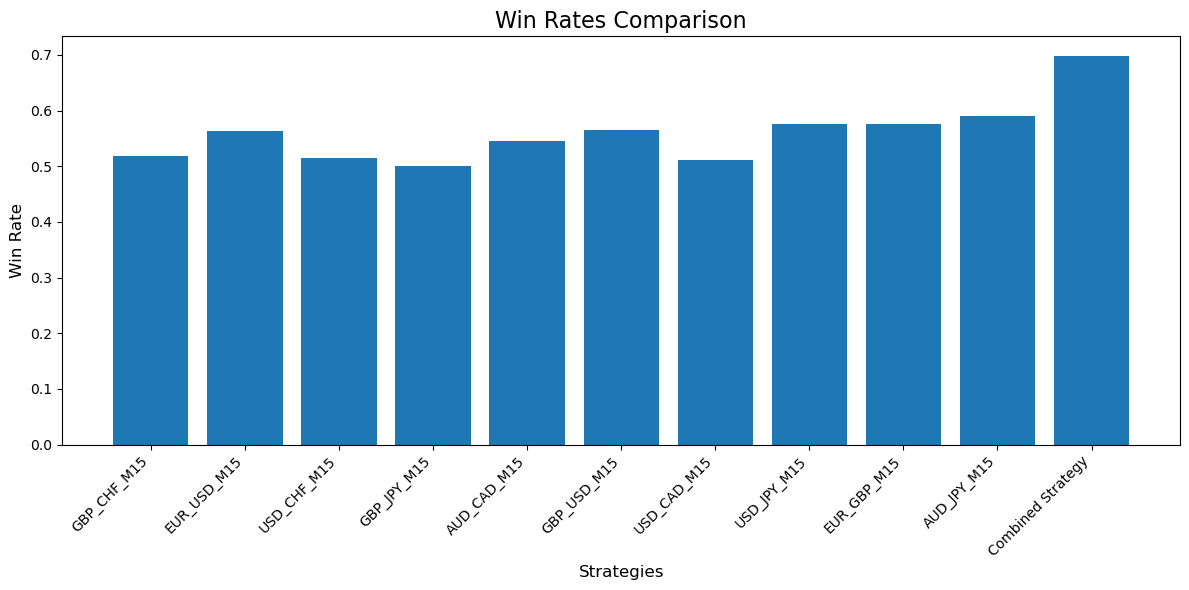


Analysis complete. Please check the generated plots for visual insights.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.spatial.distance import pdist, squareform
from sklearn.preprocessing import StandardScaler

# Load the data and filter for even window numbers
def load_and_filter_data(file_path):
    df = pd.read_csv(file_path)
    df['window'] = df['window'].astype(int)
    df = df[df['window'] % 2 == 0]
    return df

# Invert strategies with negative portfolios
def invert_negative_strategies(df):
    strategy_returns = df.groupby('instrument')['test_total_actual_return'].sum()
    negative_strategies = strategy_returns[strategy_returns < 0].index
    df.loc[df['instrument'].isin(negative_strategies), 'test_total_actual_return'] *= -1
    print("Inverted strategies:", list(negative_strategies))
    return df

# Correlation Matrix and Heatmap
def plot_correlation_matrix(df):
    agg_df = df.groupby(['window', 'instrument'])['test_total_actual_return'].mean().reset_index()
    pivot_df = agg_df.pivot(index='window', columns='instrument', values='test_total_actual_return')
    corr_matrix = pivot_df.corr()
    
    plt.figure(figsize=(12, 10))
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1, center=0)
    plt.title('Correlation Matrix of Strategy Test Returns (After Inversion, Even Windows)')
    plt.tight_layout()
    plt.show()
    
    return corr_matrix

# Uncorrelated Strategy Pairs
def find_uncorrelated_pairs(corr_matrix, threshold=0.2):
    uncorrelated_pairs = []
    for i in range(len(corr_matrix.columns)):
        for j in range(i+1, len(corr_matrix.columns)):
            if abs(corr_matrix.iloc[i, j]) < threshold:
                uncorrelated_pairs.append((corr_matrix.columns[i], corr_matrix.columns[j]))
    return uncorrelated_pairs

# Hierarchical Clustering
def plot_dendrogram(corr_matrix):
    dist_matrix = 1 - corr_matrix
    condensed_dist = pdist(dist_matrix)
    linkage_matrix = linkage(condensed_dist, method='ward')
    
    plt.figure(figsize=(10, 7))
    dendrogram(linkage_matrix, labels=corr_matrix.columns)
    plt.title('Hierarchical Clustering of Strategies (After Inversion, Even Windows)')
    plt.xlabel('Strategy')
    plt.ylabel('Distance')
    plt.show()

# Performance Metrics
def calculate_performance_metrics(df):
    grouped = df.groupby('instrument')
    total_returns = grouped['test_total_actual_return'].sum()
    avg_returns = grouped['test_total_actual_return'].mean()
    std_returns = grouped['test_total_actual_return'].std()
    sharpe_ratios = avg_returns / std_returns
    
    metrics = pd.DataFrame({
        'Total Return': total_returns,
        'Average Return': avg_returns,
        'Standard Deviation': std_returns,
        'Sharpe Ratio': sharpe_ratios
    })
    
    return metrics.sort_values('Sharpe Ratio', ascending=False)

# Time-varying Correlations
def plot_rolling_correlations(df, window=20):
    agg_df = df.groupby(['window', 'instrument'])['test_total_actual_return'].mean().reset_index()
    pivot_df = agg_df.pivot(index='window', columns='instrument', values='test_total_actual_return')
    rolling_corr = pivot_df.rolling(window=window).corr()
    
    plt.figure(figsize=(12, 8))
    for i in range(len(pivot_df.columns)):
        for j in range(i+1, len(pivot_df.columns)):
            plt.plot(rolling_corr.index.levels[0], rolling_corr.loc[(slice(None), pivot_df.columns[i]), pivot_df.columns[j]], 
                     label=f'{pivot_df.columns[i]} vs {pivot_df.columns[j]}')
    
    plt.title(f'Rolling Correlations (Window: {window}) After Inversion, Even Windows')
    plt.xlabel('Window')
    plt.ylabel('Correlation')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

# Drawdown Analysis
def calculate_drawdowns(df):
    try:
        agg_df = df.groupby(['window', 'instrument'])['test_total_actual_return'].mean().reset_index()
        pivot_df = agg_df.pivot(index='window', columns='instrument', values='test_total_actual_return')
        cumulative_returns = (1 + pivot_df).cumprod()
        peak = cumulative_returns.cummax()
        drawdowns = (peak - cumulative_returns) / peak
        return drawdowns.fillna(0)
    except Exception as e:
        print(f"Error in calculate_drawdowns: {e}")
        print("Intermediate data shapes:")
        print(f"agg_df shape: {agg_df.shape}")
        print(f"pivot_df shape: {pivot_df.shape}")
        print(f"cumulative_returns shape: {cumulative_returns.shape}")
        return pd.DataFrame()  # Return empty DataFrame on error

def plot_drawdowns(drawdowns):
    plt.figure(figsize=(15, 10))
    for column in drawdowns.columns:
        plt.plot(drawdowns.index, drawdowns[column], label=column, alpha=0.5)
    plt.title('Drawdowns for Each Strategy (After Inversion, Even Windows)', fontsize=16)
    plt.xlabel('Window', fontsize=12)
    plt.ylabel('Drawdown', fontsize=12)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=10)
    plt.tight_layout()
    plt.show()

# Strategy Combination
def combine_strategies(df, strategies):
    strategy_df = df[df['instrument'].isin(strategies)]
    combined_returns = strategy_df.groupby('window')['test_total_actual_return'].mean()
    
    # Calculate win rate
    win_rate = (combined_returns > 0).mean()
    print(f"\nWin Rate of Combined Strategy: {win_rate:.2%}")
    
    return combined_returns, win_rate

# Main execution
if __name__ == "__main__":
    # Load and filter data
    df = load_and_filter_data('combined_output.csv')
    
    # Apply the inversion
    df = invert_negative_strategies(df)
    
    # 1. Correlation Matrix and Heatmap
    corr_matrix = plot_correlation_matrix(df)
    
    # 2. Uncorrelated Strategy Pairs
    uncorrelated_pairs = find_uncorrelated_pairs(corr_matrix)
    print("Uncorrelated Strategy Pairs:")
    for pair in uncorrelated_pairs[:10]:  # Print first 10 pairs
        print(f"{pair[0]} and {pair[1]}")
    
    # 3. Hierarchical Clustering
    plot_dendrogram(corr_matrix)
    
    # 4. Performance Metrics
    performance_metrics = calculate_performance_metrics(df)
    print("\nPerformance Metrics (After Inversion, Even Windows):")
    print(performance_metrics)
    
    # 5. Time-varying Correlations
    plot_rolling_correlations(df)
    
    # 6. Drawdown Analysis
    drawdowns = calculate_drawdowns(df)
    plot_drawdowns(drawdowns)
    
    # Calculate maximum drawdown for each strategy
    max_drawdowns = drawdowns.max()
    top_10_low_drawdown = max_drawdowns.nsmallest(10)
    
    print("\nTop 10 Strategies with Lowest Maximum Drawdown:")
    print(top_10_low_drawdown)
    
    # 7. Strategy Combination with prominent combined strategy and win rate
    low_drawdown_strategies = top_10_low_drawdown.index.tolist()
    combined_returns, win_rate = combine_strategies(df, low_drawdown_strategies)
    
    plt.figure(figsize=(15, 10))
    
    # Plot individual strategies with lower alpha
    for strategy in low_drawdown_strategies:
        strategy_returns = df[df['instrument'] == strategy].groupby('window')['test_total_actual_return'].mean()
        plt.plot(strategy_returns.index, strategy_returns.cumsum(), label=strategy, alpha=0.3)
    
    # Plot combined strategy with thick, prominent line
    plt.plot(combined_returns.index, combined_returns.cumsum(), label=f'Combined Strategy (Win Rate: {win_rate:.2%})', 
             color='red', linewidth=3, alpha=1)
    
    plt.title('Cumulative Returns of Combined Strategy vs Individual Strategies (Low Drawdown, Even Windows)', fontsize=16)
    plt.xlabel('Window', fontsize=12)
    plt.ylabel('Cumulative Return', fontsize=12)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=10)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

    # 8. Additional win rate analysis
    print("\nWin Rate Analysis:")
    print(f"Combined Strategy Win Rate: {win_rate:.2%}")
    
    # Calculate win rates for individual strategies
    individual_win_rates = {}
    for strategy in low_drawdown_strategies:
        strategy_returns = df[df['instrument'] == strategy].groupby('window')['test_total_actual_return'].mean()
        strategy_win_rate = (strategy_returns > 0).mean()
        individual_win_rates[strategy] = strategy_win_rate
        print(f"{strategy} Win Rate: {strategy_win_rate:.2%}")
    
    # Plot win rates comparison
    plt.figure(figsize=(12, 6))
    strategies = list(individual_win_rates.keys()) + ['Combined Strategy']
    win_rates = list(individual_win_rates.values()) + [win_rate]
    plt.bar(strategies, win_rates)
    plt.title('Win Rates Comparison', fontsize=16)
    plt.xlabel('Strategies', fontsize=12)
    plt.ylabel('Win Rate', fontsize=12)
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

    print("\nAnalysis complete. Please check the generated plots for visual insights.")